In [1]:
import glob
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
from netCDF4 import Dataset
import numpy as np

from scipy.ndimage import distance_transform_edt, zoom
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-el5zry3l because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Tests for one_hot_encoding functions

In [2]:
def ice_type(stage):
        """
        Gives back the index the concentration or 1 should be on.
        Each index corresponds to a particular ice type
        (0: Young ice; 1: First Year ice; 2: Multi year ice ; 3: Ice free).
        The values on which depends this classification are described ine the
        ASIP-v2 manual.
        Parameters
        ----------
        stage : integer
            stage of development.
        Returns
        -------
        index_ : integer
            index of the list where the value (0/1 or concentration) will be.
        """
        index_= None
        if stage in range (0, 83):
            #print('ice_free')
            index_ = 0
        if stage in range(83, 86):
            #print('Young ice')
            index_=1
        if stage in range(87, 94):
            #print('First year ice')
            index_=2
        if stage in range(95, 98):
            #print('multiyear ice')
            index_=3
        return index_

def one_hot_continous(vector_param):
        """
        Returns the list of one-hot encoded values in terms of concentration
        corresponding to ice types based on concentration and stage of development
        of thickest, second thickest and thrid thickest ice.

        Parameters
        ----------
        vector_param : list
            all parameters in a vector.

        Returns
        -------
        result : list
            List of one-hot encoded (in terms of concentration) values
            corresponding to ice types.
        """
        result = [0, 0, 0, 0]
        vector_param = vector_param.squeeze()
        for ice in range(3): # in a output there are 3 data for the 3 most present ice
            if vector_param[1+ice*3]==(-9): 
                continue
            if vector_param[2+ice*3]==(-9): 
                continue
            icetype = ice_type(vector_param[2+ice*3])
            result[icetype] += round(vector_param[1+ice*3]/100,1)
        if max(result) == 0:
             result[0] = 1
        else:
             result[0] = 1-sum(result[1:])
        for i in range(len(result)):
            result[i] = round(result[i],1)
        return result

def one_hot_continous_sod_f(vector_param):
    """
    Converts the output parameter vector ([ct,ca,sa,fa,...]) 
    into a vector that contains the concentration percentages for the combinations.

    Parameters
    ----------
    vector_param : list
        all parameters in a vector.

    Returns
    -------
    result : list
        List of percentage concentrations for each work combination.
    """
    
    result = [0]*len(list_combi)
    vector_param = vector_param.squeeze()
    if vector_param[0] <=10 : #open weter
        combi = "0_0"
        index_combi = list_combi.index(combi)
        result[index_combi] = 1
    for ice in range(3): # in a output there are 3 data for the 3 most present ice
        if vector_param[1+ice*3] == (-9): 
            continue
        if vector_param[2+ice*3] == (-9): 
            continue
        if vector_param[3+ice*3] == (-9): 
            continue
        combi = str(int(vector_param[2+ice*3])) + '_' + str(int(vector_param[3+ice*3]))
        index_combi = list_combi.index(combi)
        result[index_combi] += vector_param[1+ice*3]/100
    if sum(result) != 1:
        result[0] = 1-sum(result)
    for i in range(len(result)):
        result[i] = round(result[i],1)
    return result

In [3]:
#input and test_values

print("test ice_type function")
test1_stage = 2
test2_stage = 83
test3_stage = 92
test4_stage = 97

t1 = ice_type(test1_stage)
print('need   : 0')
print(f'result : {t1}')
t2 = ice_type(test2_stage)
print('need   : 1')
print(f'result : {t2}')
t3 = ice_type(test3_stage)
print('need   : 2')
print(f'result : {t3}')
t4 = ice_type(test4_stage)
print('need   : 3')
print(f'result : {t4}')

print('\n')
print("Test one_hot_continous_hugo :")
test1_hugo = np.array([91, 60, 93,  7, 40, 91,  6, -9, -9, -9])
test2_hugo =  np.array([2, -9, -9,  -9, -9, -9,  -9, -9, -9, -9])
test3_hugo =  np.array([91, 50, 85, 4, 40, 91, 6, 10, 97, 7])
test4_hugo = np.array([92, -9, 91,  8, -9, -9, -9, -9, -9, -9])

t1 = one_hot_continous(test1_hugo)
print('need   : [0, 0, 1.0, 0]')
print(f'result : {t1}')
t2 = one_hot_continous(test2_hugo)
print('need   : [1, 0, 0, 0]')
print(f'result : {t2}')
t3 = one_hot_continous(test3_hugo)
print('need   : [0.0, 0.5, 0.4, 0.1]')
print(f'result : {t3}')
t4 = one_hot_continous(test4_hugo)
print('need   : []')
print(f'result : {t4}')

print('\n')
print("Test one_hot_continous_sod_f :")
list_combi = ["0_0", "83_5", "93_6", "87_6", "95_4", "95_6", "91_5", "95_3", "95_5", "97_7", "96_6", "91_6", "87_5"]
test1_sod_f = np.array([91, 60, 95, 3, 40, 91, 5, -9, -9, -9])
test2_sod_f =  np.array([2, -9, -9,  -9, -9, -9,  -9, -9, -9, -9])
test3_sod_f =  np.array([91, 50, 83, 5, 40, 87, 6, 10, 95, 6])
test4_sod_f = np.array([92, -9, 91,  8, -9, -9, -9, -9, -9, -9])
test5_sod_f = np.array([80, 30, 97,  7, 40, 96,  6, 10, 93,  6])
test6_sod_f = np.array([10, -9, 93,  2, -9, -9, -9, -9, -9, -9])
test7_sod_f = np.array([90, 70, 91,  6, 20, 87,  5, -9, -9, -9])


t1 = one_hot_continous_sod_f(test1_sod_f)
print('need   : [0, 0, 0, 0, 0, 0, 0.4, 0.6, 0, 0, 0, 0, 0]')
print(f'result : {t1}')
t2 = one_hot_continous_sod_f(test2_sod_f)
print('need   : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]')
print(f'result : {t2}')
t3 = one_hot_continous_sod_f(test3_sod_f)
print('need   : [0, 0.5, 0, 0.4, 0, 0.1, 0, 0, 0, 0, 0, 0, 0]')
print(f'result : {t3}')
t4 = one_hot_continous_sod_f(test4_sod_f)
print('need   : []')
print(f'result : {t4}')
t5 = one_hot_continous_sod_f(test5_sod_f)
print('need   : [0.2, 0, 0.1, 0, 0, 0, 0, 0, 0, 0.3, 0.4, 0, 0]')
print(f'result : {t5}')
t6 = one_hot_continous_sod_f(test6_sod_f)
print('need   : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]')
print(f'result : {t6}')
t7 = one_hot_continous_sod_f(test7_sod_f)
print('need   : [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0.2]')
print(f'result : {t7}')


test ice_type function
need   : 0
result : 0
need   : 1
result : 1
need   : 2
result : 2
need   : 3
result : 3


Test one_hot_continous_hugo :
need   : [0, 0, 1.0, 0]
result : [0.0, 0, 1.0, 0]
need   : [1, 0, 0, 0]
result : [1, 0, 0, 0]
need   : [0.0, 0.5, 0.4, 0.1]
result : [0.0, 0.5, 0.4, 0.1]
need   : []
result : [1, 0, 0, 0]


Test one_hot_continous_sod_f :
need   : [0, 0, 0, 0, 0, 0, 0.4, 0.6, 0, 0, 0, 0, 0]
result : [0, 0, 0, 0, 0, 0, 0.4, 0.6, 0, 0, 0, 0, 0]
need   : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
result : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
need   : [0, 0.5, 0, 0.4, 0, 0.1, 0, 0, 0, 0, 0, 0, 0]
result : [0, 0.5, 0, 0.4, 0, 0.1, 0, 0, 0, 0, 0, 0, 0]
need   : []
result : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
need   : [0.2, 0, 0.1, 0, 0, 0, 0, 0, 0, 0.3, 0.4, 0, 0]
result : [0.2, 0, 0.1, 0, 0, 0, 0, 0, 0, 0.3, 0.4, 0, 0]
need   : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
result : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
need   : [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7,

# Tests for get_array of distanceBatches

In [4]:
def get_array(array_poly):
    """
    create the distance matrix between the pixels and the borders of the icechart polygons 
    """
    poly = array_poly
    orig_shape = poly.shape
    poly = poly[::10, ::10]
    new_shape = poly.shape
    factor = np.array(orig_shape) / np.array(new_shape)
    list_poly=np.unique(poly)
    distance=distance_transform_edt(poly==list_poly[0], return_distances=True, return_indices=False)
    for id_poly in list_poly[1:] :
        distance1=distance_transform_edt(poly==id_poly, return_distances=True, return_indices=False)
        distance[distance == 0] = distance1[distance == 0]
    distance = zoom(distance, factor, order=1)*10
    return distance

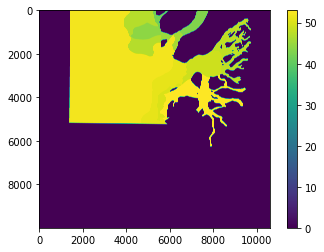

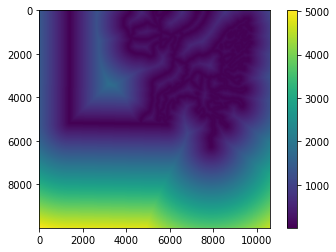

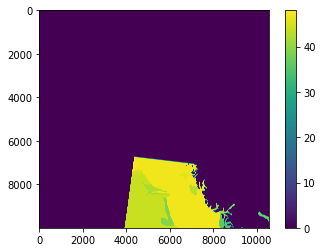

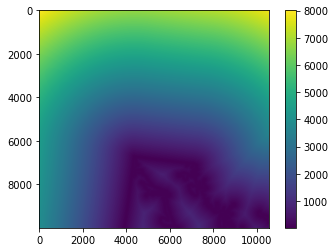

In [5]:
#input and test_values

ifile = '/tf/data/input/20180404T205505_S1B_AMSR2_Icechart-Greenland-CentralWest.nc'
ifile2 = '/tf/data/input/20180410T084537_S1B_AMSR2_Icechart-Greenland-SouthEast.nc'
files = [ifile, ifile2]
for file in files :
    ds = Dataset(file, format="NETCDF4")
    ic = ds['polygon_icechart'][:, :].filled(0)
    plt.imshow(ic)
    plt.colorbar()
    plt.show()
    # p_codes = ds['polygon_codes'][:]
    # print(p_codes)

    distance = get_array(ic)
    plt.imshow(distance)
    plt.colorbar()
    plt.show()


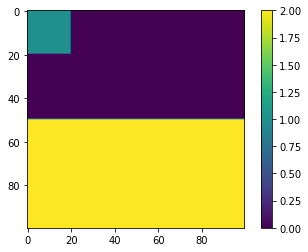

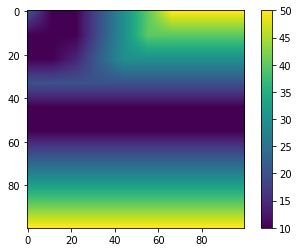

In [6]:
test1 = np.zeros((100,100))
test1[:20,:20]=1
test1[50:]=2
plt.imshow(test1)
plt.colorbar()
plt.show()

result1 = get_array(test1)
plt.imshow(result1)
plt.colorbar()
plt.show()
